<a href="https://colab.research.google.com/github/abdipourasl/OCD/blob/main/MNE_Conn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import tensorflow as tf
import os
import cv2
import imghdr
from google.colab import drive
%matplotlib inline
import os
import os.path as op
!pip install mne
import mne
import numpy as np
import pandas as pd
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/')
data_dir= '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<div class="alert alert-block alert-success">
<h1>EEG Preprocessing with MNE</h1>
</div>

### 1. Importing Raw  Data

In [63]:
examples_dir = os.path.join('/content/drive/My Drive/','OCD_subj46.EDF')  # Path to the raw EEG Data folder
raw = mne.io.read_raw_edf(os.path.join('/content/drive/My Drive/','OCD_subj46.EDF'))                                                         # Loading continuous data
print(raw)

Extracting EDF parameters from /content/drive/My Drive/OCD_subj46.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<RawEDF | OCD_subj46.EDF, 23 x 165500 (331.0 s), ~27 kB, data not loaded>


In [64]:
raw.crop(tmin=5., tmax=50.)

<RawEDF | OCD_subj46.EDF, 23 x 22501 (45.0 s), ~27 kB, data not loaded>

### 2. Downsampling

In [65]:
raw.resample(250, npad="auto")    # set sampling frequency to 256 points per second

<RawEDF | OCD_subj46.EDF, 23 x 11250 (45.0 s), ~2.0 MB, data loaded>

### 3. Channel Selection

In [66]:
raw.pick_channels(['Fp1','Fp2','F7','F3','F4','F8','T3','C3','C4','T4','T5','P3','P4','T6','O1','O2','Fz','Cz','Pz'],ordered=True)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<RawEDF | OCD_subj46.EDF, 19 x 11250 (45.0 s), ~1.7 MB, data loaded>

In [67]:
print(raw.info["ch_names"])
print(raw)

['Fp1', 'Fp2', 'F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'C4', 'T4', 'T5', 'P3', 'P4', 'T6', 'O1', 'O2', 'Fz', 'Cz', 'Pz']
<RawEDF | OCD_subj46.EDF, 19 x 11250 (45.0 s), ~1.7 MB, data loaded>


>according to the Nyquist frequency, sampling rate should be at least two times of frequency.
Moreover, 128 points are suitable and 256 points are desirable


### 4. Rereference

In [ ]:
raw.set_eeg_reference('average', projection=True).apply_proj()  # re-referencing with the virtual average reference

### 5. Clean Data - ASR



In [68]:
raw_uncleaned = raw.copy()

In [ ]:
ssp_projectors = raw.info["projs"]
raw.del_proj()

First of all, we initialize an instance of the `ASR` class, which stores predefined parameters (like the rejection threshold), the functional procedures as well as the parameters matrices that are used to transform data.

If you are familiar with [scikit-learn](https://scikit-learn.org/stable/), you will notice that a lot of MNE's automated cleaning and decoding functions work similar to scikit learn and can usually be seamlessly integrated into sklearn pipelines (which is due to the fact that some of the MNE developers also work on sklearn). This is especially helpful for brain decoding and BCI applications.

At initialization our ASR instance needs to know the sampling frequency of our raw data (which is required for multiple features of the algorithms). We also tell it to repair portions of data whose variance is 5 standard deviations larger than the reference data.

In [ ]:
!pip install -U autoreject
!pip install https://api.github.com/repos/autoreject/autoreject/zipball/master
#python -c 'import autoreject'
from autoreject import AutoReject
ar = AutoReject()
epochs_clean = ar.fit_transform(epochs)  # doctest: +SKIP
from autoreject import get_rejection_threshold
reject = get_rejection_threshold(epochs)  # doctest: +SKIP

In [ ]:
!pip install asrpy -q
from asrpy import ASR
asr = ASR(sfreq=raw.info["sfreq"], cutoff=5)

Now we fit our asr object to the data.

We will use our entire raw data to fit. If your dataset is too large, you could also just use a fraction of the data for fitting. Theoretically, you could fit your cleaning algorithm to one dataset and then apply it to another, but this is very unusual and only makes sense for very specific experimental setups.

In [ ]:
asr.fit(raw)

After our `asr` object was fitted to a certain dataset, we can apply it to our recorded raw data. The uncleaned data is transformed (/interpolated) according to the ASR procedure.

In [ ]:
raw._data = asr.transform(raw)

In [ ]:
scalings= {"eeg":2e-5}

print("Uncleaned data")
raw_uncleaned.plot(scalings=scalings);

print("Cleaned data")
raw._data.plot(start=0.25, scalings=scalings);

### 6. Filtering the data

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
<ipython-input-69-194f3f2586e1>:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=100);


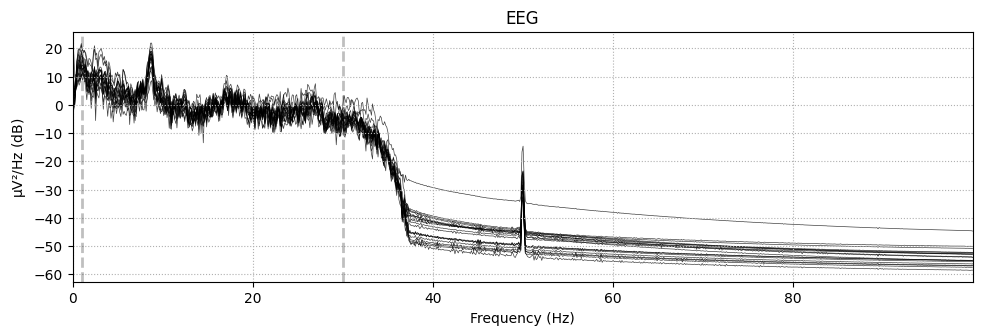

In [69]:
raw.filter(1, 30, fir_design='firwin', picks=['eeg'])  # band-pass filter from 1 to 30 frequency over just
                                                       # EEG channel and not EEG channel
raw.plot_psd(fmax=100);

>Lw-pass filter with 1 Hz cutoff frequency for removing low-frequency drifts.
    High-pass filter with 30 Hz cutoff frequency for deteriorating the effect of
    the AC power line frequency, cell phones, the geomagnetic field and so forth.
    Therefore, a band-pass filter was used in the range 1Hz-30Hz with one step.
    You can apply another band pass filter due to your own assumtions and hypotheses.
    I recommend that band pass filtering would be better to occurr before the EEG
    data epoching and artifact removal with ICA.

In [70]:
raw.notch_filter(freqs=[16.667, 50]); # bandstop the train and power grid

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


<ipython-input-71-f37641293c7d>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=100);


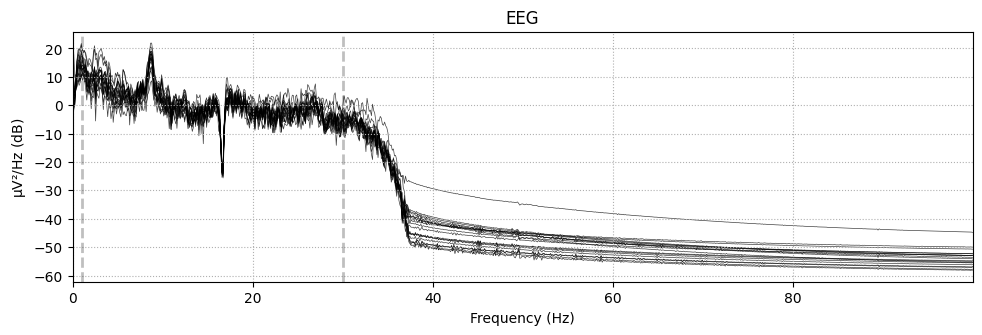

In [71]:
raw.plot_psd(fmax=100);

### 7. Visual Inspection

###### 7.1 Plot continuous data

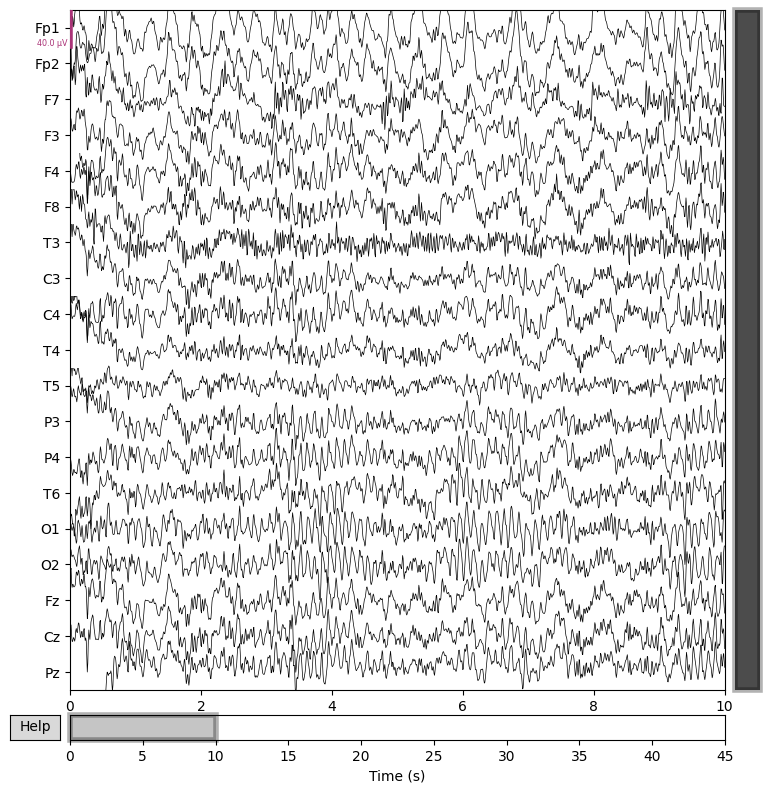

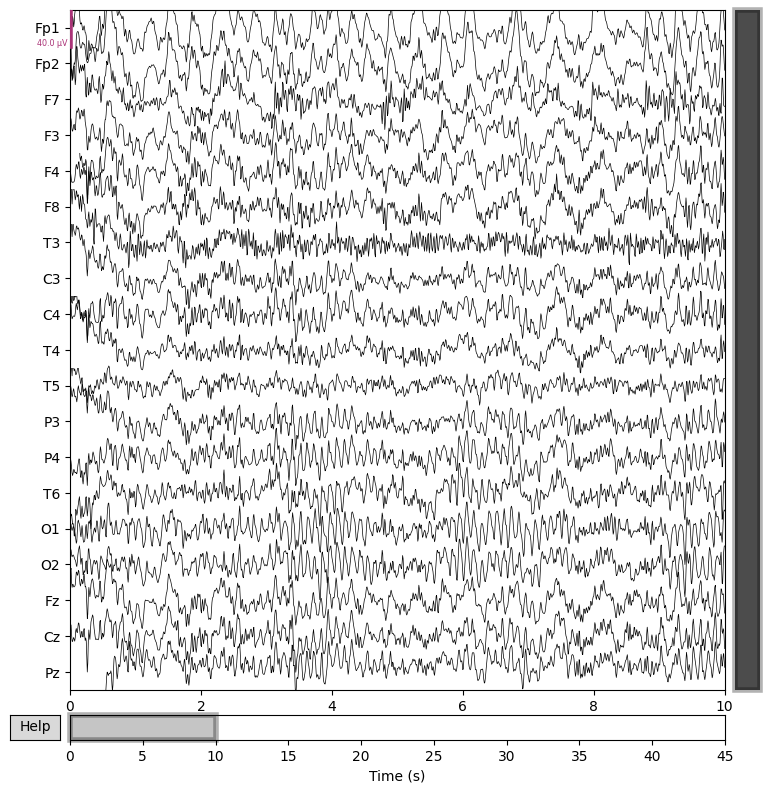

In [72]:
#%matplotlib qt
raw.plot()       # plot the EEG data. Use the '%matplotlib qt' to see
                 # the data in a bright way and move conveniently

>Use of visual inspection to reject some segments which have abnormal frequency,
     signal discontinuous, abrupt jumping, irrelevant-task and son on.
     Trace all EEG channels during time.
     The best way to remove segtion of the data is deleting annotations in the segtion.
     In addition, when you see irrelavant task or noise segemt in specefict channel,
     you shoud remove the sement in all channels
     Afterward, The instances of noisy segment which should be removed are created by
     providing a EXCELL file with two columns of onsets and  offsets with descriptions
     for each segment. The onsets and offsets are marked as seconds. onset refers to time
     from start of the data. offset refers to time from end of the data

###### 7.2 channel bad correction

In [ ]:
#raw.info['bads'] = ['Fp1','Fp2','Fpz']         # Select bad channels visually to interpolate them with channels
                                               # Sleceted channels are not real
raw = raw.interpolate_bads(reset_bads=False)

###### 7.3 Delete annotations

In [ ]:
visual_inspection = pd.read_csv(examples_dir + "\\sub-005_visual_inspection.csv")  # Path to annotation folder
                                                                                  # remove each segment with start and end time
for i in range(visual_inspection.shape[0]):
    result = np.where((mne.events_from_annotations(raw)[0][:,0] > visual_inspection['Start'][i]*256) &
                      (mne.events_from_annotations(raw)[0][:,0] < visual_inspection['End'][i]*256));
    raw.annotations.delete(result)

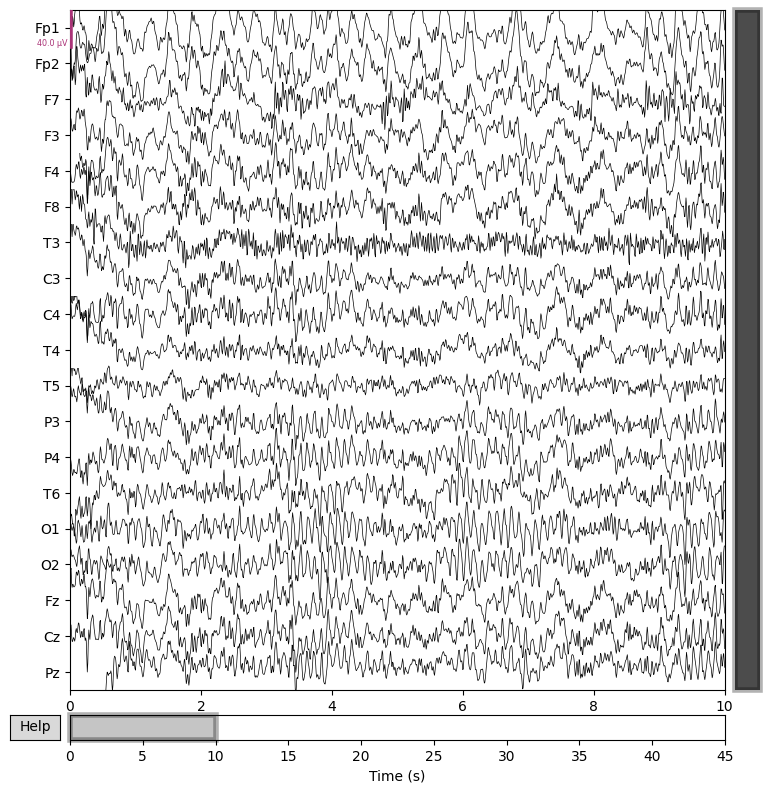

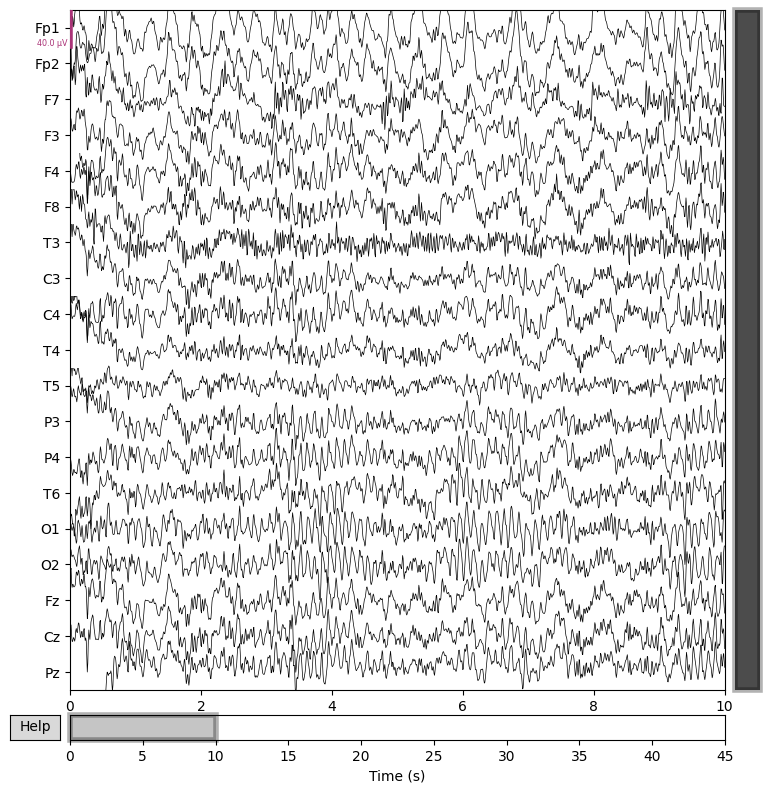

In [73]:
raw.plot()    # Let's see the data again to be sure that the noisy segemnts have been deleted

### 8. Segmenting continuous data into epochs and setting Ampilitude ceriteria

In [ ]:
events_from_annot, event_dict = mne.events_from_annotations(raw)# Get events and event_id from an Annotations object.
event_dict = {'74':74, '75':75, '76':76}                        # Event dictionaries to extract epochs from continuous data,
reject_criteria = dict(eeg=100e-6)                              # Absolute Amplitude of each epoch sould be smaller than 100 μV
                                                                # tmin is start time before event, tmax is end time after event
                                                                # - 100 ms (baseline) of cue's onset to 600 ms
epochs = mne.Epochs(raw, events_from_annot, event_id=event_dict, tmin=-0.1, tmax=1.6,
                    reject=reject_criteria, baseline = (None,0), preload=True, picks=['eeg'])


### 9. Connectivity



In [74]:
!pip install -U mne-connectivity
import mne_connectivity


In [75]:
 mne_connectivity.SpectralConnectivity(raw, freqs=(8., 20.), n_nodes=19, names=None, indices='all', method='plv', spec_method=None, n_epochs_used=None)

TypeError: ignored

In [76]:
m=mne_connectivity.spectral_connectivity_time(raw, freqs=(8., 20.), method='plv', average=False, indices=None, sfreq=raw.info["sfreq"], fmin=None, fmax=None, fskip=0, faverage=False, sm_times=0, sm_freqs=1)


ValueError: ignored